
#                                          Исследование технологического процесса очистки золота

## 1. Подготовка данных
### 1.1. Изучение файлов

In [19]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
#!pip install imblearn
#from imblearn.over_sampling import SMOTE
from multiprocessing import cpu_count
cpu_count()

8

In [20]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=True)
#df_train=df_train.set_index("date")

print(df_train.info())
print(df_train.head(1))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [21]:
print(df_test.info())

print(df_test.head(1))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [22]:
print(df_full.info())
print(df_full.head(1))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

### 1.2. Проверка правильно ли рассчитана эффективность обогащения. Вычисление её на обучающей выборке для признака rougher.output.recovery. Поиск MAE между моими расчётами и значением признака.

In [23]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
df_train['calc_recovery'] = C*(F-T)/(F*(C-T))*100

print('MAE:', mean_absolute_error(df_train['rougher.output.recovery'], df_train['calc_recovery']))
print("Median_df:", df_train['rougher.output.recovery'].median() )
print("Median_calc:", df_train['calc_recovery'].median() )


MAE: 9.73512347450521e-15
Median_df: 85.2994620986978
Median_calc: 85.29946209869779


Разницы практически нет, похоже она только в округлении.

### 1.3. Анализ признаков, недоступных в тестовой выборке. Что это за параметры? К какому типу относятся?

In [24]:
set(df_train).symmetric_difference(set(df_test))

{'calc_recovery',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 

В тестовой выборке отсуствуют:

final — финальные характеристики, 

output — параметры продукта, 

calculation — расчётные характеристики

### 1.4. Предобработка данных.

Добавим в тестовую выборку целевые признаки: rougher.output.recovery, final.output.recovery.

In [25]:
columns = ['rougher.output.recovery', 'final.output.recovery']
df_test.loc[:, columns] = df_full[columns]
df_test.head(10)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640,79.613867,57.124195
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984,79.957839,55.193988
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657,82.183217,56.696216
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716,83.531184,60.363812


In [26]:
df_full.loc["2016-09-01 00:59:59", 'rougher.output.recovery']

89.99342112260429

Удалим из тренировочной выборки колонки, отсутствующие в тестовой, так как эти признаки зависимы от остальных.

In [27]:
#ignored_columns = ["final.output.concentrate_ag", "final.output.concentrate_pb", "final.output.concentrate_sol" ,  "final.output.concentrate_au", "final.output.tail_ag", "final.output.tail_pb", "final.output.tail_sol", "final.output.tail_au",  "primary_cleaner.output.concentrate_ag", "primary_cleaner.output.concentrate_pb", "primary_cleaner.output.concentrate_sol", "primary_cleaner.output.concentrate_au", "primary_cleaner.output.tail_ag", "primary_cleaner.output.tail_pb", "primary_cleaner.output.tail_sol", "primary_cleaner.output.tail_au", "rougher.calculation.sulfate_to_au_concentrate",  "rougher.calculation.floatbank10_sulfate_to_au_feed", "rougher.calculation.floatbank11_sulfate_to_au_feed", "rougher.calculation.au_pb_ratio", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb", "rougher.output.concentrate_sol", "rougher.output.concentrate_au",  "rougher.output.tail_ag", "rougher.output.tail_pb", "rougher.output.tail_sol", "rougher.output.tail_au", "secondary_cleaner.output.tail_ag", "secondary_cleaner.output.tail_pb", "secondary_cleaner.output.tail_sol", "secondary_cleaner.output.tail_au","calc_recovery"]   
df_train=df_train.drop(["final.output.concentrate_ag", "final.output.concentrate_pb", "final.output.concentrate_sol" ,  "final.output.concentrate_au", "final.output.tail_ag", "final.output.tail_pb", "final.output.tail_sol", "final.output.tail_au",  "primary_cleaner.output.concentrate_ag", "primary_cleaner.output.concentrate_pb", "primary_cleaner.output.concentrate_sol", "primary_cleaner.output.concentrate_au", "primary_cleaner.output.tail_ag", "primary_cleaner.output.tail_pb", "primary_cleaner.output.tail_sol", "primary_cleaner.output.tail_au", "rougher.calculation.sulfate_to_au_concentrate",  "rougher.calculation.floatbank10_sulfate_to_au_feed", "rougher.calculation.floatbank11_sulfate_to_au_feed", "rougher.calculation.au_pb_ratio", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb", "rougher.output.concentrate_sol", "rougher.output.concentrate_au",  "rougher.output.tail_ag", "rougher.output.tail_pb", "rougher.output.tail_sol", "rougher.output.tail_au", "secondary_cleaner.output.tail_ag", "secondary_cleaner.output.tail_pb", "secondary_cleaner.output.tail_sol", "secondary_cleaner.output.tail_au","calc_recovery"], axis=1)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       14149 non-null  float64
 1   primary_cleaner.input.sulfate               14129 non-null  float64
 2   primary_cleaner.input.depressant            14117 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14049 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      1414

Заполним пропуски в тренировочной и тестовой выборке предыдущими значениями(так как близкие по дате и времени параметры будут близки по значению): 

In [28]:
df_test=df_test.fillna(method='ffill')
df_train=df_train.fillna(method='ffill')
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       14149 non-null  float64
 1   primary_cleaner.input.sulfate               14149 non-null  float64
 2   primary_cleaner.input.depressant            14149 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14149 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14149 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      1414

### Вывод:

1. Эффективность расчитана верно 
2. В тестовой выборке отсуствуют:

final — финальные характеристики,

output — параметры продукта,

calculation — расчётные характеристики

3. Привели в соответствие тестовую и тренировочную выборку

4. Заполнили пропуски в обеих выборках предыдущими значениями

## 2. Анализ данных
### 2.1. Проанализируем как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Концентрация золота Au:

array([[<AxesSubplot:title={'center':'rougher.input.feed_au'}>,
        <AxesSubplot:title={'center':'rougher.output.concentrate_au'}>],
       [<AxesSubplot:title={'center':'primary_cleaner.output.concentrate_au'}>,
        <AxesSubplot:title={'center':'final.output.concentrate_au'}>]],
      dtype=object)

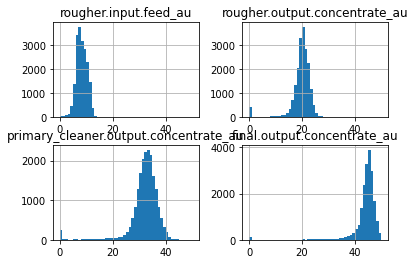

In [29]:
df_full.hist(['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], bins=50, range=(0,50))  

После флотации концентрация золота увеличилась, после первичной очистки увеличилось еще, а после вторичной очистки увеличилось еще сильнее.

Концентрация серебра Ag:

array([[<AxesSubplot:title={'center':'rougher.input.feed_ag'}>,
        <AxesSubplot:title={'center':'rougher.output.concentrate_ag'}>],
       [<AxesSubplot:title={'center':'primary_cleaner.output.concentrate_ag'}>,
        <AxesSubplot:title={'center':'final.output.concentrate_ag'}>]],
      dtype=object)

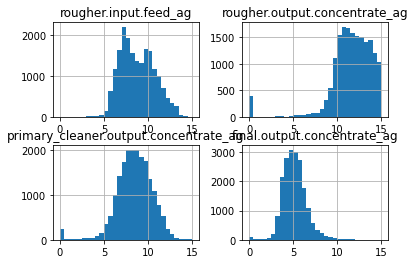

In [30]:
df_full.hist(['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], bins=30, range=(0,15))  

После флотации концентрация серебра увеличилась, а после первичной очистки вернулась обратно, а после вторичной очистки уменьшилось еще сильнее.

Концентрация свинца Pb:

array([[<AxesSubplot:title={'center':'rougher.input.feed_pb'}>,
        <AxesSubplot:title={'center':'rougher.output.concentrate_pb'}>],
       [<AxesSubplot:title={'center':'primary_cleaner.output.concentrate_pb'}>,
        <AxesSubplot:title={'center':'final.output.concentrate_pb'}>]],
      dtype=object)

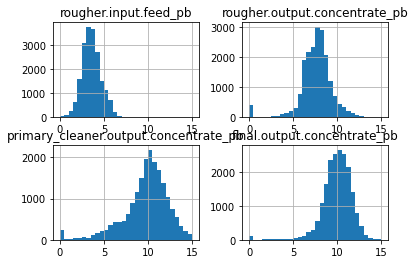

In [31]:
df_full.hist(['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'], bins=30, range=(0,15))  

После флотации концентрация свинца увеличилась, а после первичной очистки тоже увеличилась, а после вторичной очистки не изменилась.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

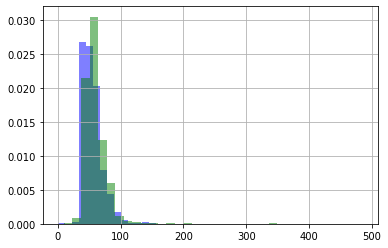

In [32]:
df_test['rougher.input.feed_size'].hist(bins=35, alpha=0.5, color='blue', density=True)
df_train['rougher.input.feed_size'].hist(bins=35, alpha=0.5, color='green', density=True);

Распределения не сильно отличаются.

### 2.3. Исслование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

array([[<AxesSubplot:title={'center':'rougher.input.feed_pb'}>,
        <AxesSubplot:title={'center':'rougher.output.concentrate_pb'}>],
       [<AxesSubplot:title={'center':'primary_cleaner.output.concentrate_pb'}>,
        <AxesSubplot:title={'center':'final.output.concentrate_pb'}>]],
      dtype=object)

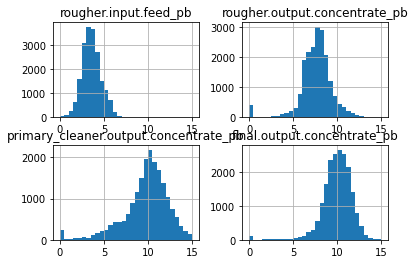

In [33]:
df_full.hist(['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'], bins=30, range=(0,15))  

array([[<AxesSubplot:title={'center':'rougher_input_feed_sum'}>,
        <AxesSubplot:title={'center':'rougher_output_concentrate_sum'}>],
       [<AxesSubplot:title={'center':'primary_cleaner_output_concentrate_sum'}>,
        <AxesSubplot:title={'center':'final.output.concentrate_sum'}>]],
      dtype=object)

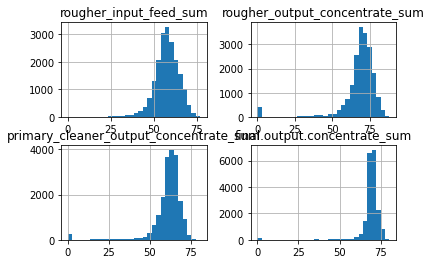

In [34]:
df_full['rougher_input_feed_sum'] = df_full['rougher.input.feed_au']+df_full['rougher.input.feed_ag']+df_full['rougher.input.feed_pb']+df_full['rougher.input.feed_sol']
df_full['rougher_output_concentrate_sum'] = df_full['rougher.output.concentrate_au']+df_full['rougher.output.concentrate_ag']+ df_full['rougher.output.concentrate_pb']+df_full['rougher.output.concentrate_sol']
df_full['primary_cleaner_output_concentrate_sum'] = df_full['primary_cleaner.output.concentrate_au']+df_full['primary_cleaner.output.concentrate_ag']+ df_full['primary_cleaner.output.concentrate_pb']+df_full['primary_cleaner.output.concentrate_sol']
df_full['final.output.concentrate_sum'] = df_full['final.output.concentrate_au']+df_full['final.output.concentrate_pb']+df_full['final.output.concentrate_ag']+df_full['final.output.concentrate_sol']
df_full.hist(['rougher_input_feed_sum','rougher_output_concentrate_sum', 'primary_cleaner_output_concentrate_sum', 'final.output.concentrate_sum'],bins=30)

После флотации суммарная концентрация увеличилась, а после первичной очистки вернулась обратно, а после вторичной очистки сильно увеличилась.

На графике видны нулевые значения суммарных концентраций - это аномальные значения, но из теста мы не можем удалять, а удалив только из трейна, трейн и тест разъедутся по распределению, что может привести к некорректной оценке качества модели.

### Выводы:

1. После флотации концентрация золота увеличилась, после первичной очистки увеличилось еще, а после вторичной очистки увеличилось еще сильнее.

2. После флотации концентрация серебра увеличилась, а после первичной очистки вернулась обратно, а после вторичной очистки уменьшилось еще сильнее.

3. После флотации концентрация свинца увеличилась, а после первичной очистки тоже увеличилась, а после вторичной очистки не изменилась.

4. Распределения размеров гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга

5. После флотации суммарная концентрация увеличилась, а после первичной очистки вернулась обратно, а после вторичной очистки сильно увеличилась. На графике суммарных концентраций видны нулевые значения суммарных концентраций - это аномальные значения, но из теста мы не можем удалять, а удалив только из трейна, трейн и тест разъедутся по распределению, что может привести к некорректной оценке качества модели.

# 3. Построение модели
## 3.1. Напишем функцию для вычисления итоговой sMAPE.


In [35]:
def smape (pred, targ):
    smape_sum=0
    for i in range(len(targ)):
        sm=abs(targ[i]-pred[i])/((abs(targ[i])+abs(pred[i]))/2)
        smape_sum+=sm
    smape = smape_sum/len(targ)*100
   
    return smape


## 3.2. Обучение разных моделей и оценка их качества кросс-валидацией. Выбор лучшщй  модели и проверка её на тестовой выборке.

In [36]:
target_rou = df_train['rougher.output.recovery']
target_fin = df_train['final.output.recovery']
features = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rou = df_test['rougher.output.recovery']
target_test_fin = df_test['final.output.recovery']
features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [37]:
smape_score = make_scorer(smape, greater_is_better=False)

In [38]:
%%time
model_rou = RandomForestRegressor(random_state=12345)
param = {
    'max_depth': range(1, 10, 2),
    'n_estimators': range(20, 200, 10)
}
gs_rou = GridSearchCV(model_rou, param, scoring=smape_score, cv=5)
gs_rou.fit(features, target_rou)

KeyboardInterrupt: 

In [24]:
gs_rou.best_params_

{'max_depth': 5, 'n_estimators': 20}

In [25]:
gs_rou.best_score_

-10.983552091759812

In [ ]:
%%time
model_fin = RandomForestRegressor(random_state=12345)
param = {
    'max_depth': range(1, 10, 2),
    'n_estimators': range(20, 200, 10)
}
gs_fin = GridSearchCV(model_fin, param, scoring=smape_score, cv=5)
gs_fin.fit(features, target_fin)

In [27]:
gs_fin.best_params_

{'max_depth': 5, 'n_estimators': 60}

In [28]:
gs_fin.best_score_

-10.144852837722885

In [29]:
model_rou = LinearRegression()

In [30]:
scores = cross_val_score(model_rou, features, target_rou, cv=5, scoring=smape_score)
score = -scores.mean()
print('Средняя оценка качества модели:', score)

Средняя оценка качества модели: 12.802483458481992


In [31]:
model_fin = LinearRegression()

In [32]:
scores = cross_val_score(model_fin, features, target_fin, cv=5, scoring=smape_score)
score = -scores.mean()
print('Средняя оценка качества модели:', score)

Средняя оценка качества модели: 12.245300320302288


Лучшая модель 1: model_rou = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=20)

Лучшая модель 2: model_fin = RandomForestRegressor(random_state=12345,  max_depth=5, n_estimators=60)

Проверим модели на тестовой выборке:

In [38]:
model_rou = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=20)

In [39]:
scores = cross_val_score(model_rou, features_test, target_test_rou, cv=5, scoring=smape_score)
score = -scores.mean()
print('Средняя оценка качества модели:', score)

Средняя оценка качества модели: 11.921859662931272


In [40]:
model_fin = RandomForestRegressor(random_state=12345,  max_depth=5, n_estimators=60)

In [41]:
scores = cross_val_score(model_fin, features_test, target_test_fin, cv=5, scoring=smape_score)
score = -scores.mean()
print('Средняя оценка качества модели:', score)

Средняя оценка качества модели: 11.199049035381105


Сравним полученные значения с моделью DummyRegressor:

In [39]:
dummy_regr = DummyRegressor(strategy="mean")

In [40]:
scores = cross_val_score(dummy_regr, features_test, target_test_fin, cv=5, scoring=smape_score)
score = -scores.mean()
print('Средняя оценка качества модели:', score)

Средняя оценка качества модели: 9.582188124767514


In [41]:
scores = cross_val_score(dummy_regr, features_test, target_test_rou, cv=5, scoring=smape_score)
score = -scores.mean()
print('Средняя оценка качества модели:', score)

Средняя оценка качества модели: 9.015842300446108


## Выводы:

1. Эффективность обогащения рассчитана правильно

2. После флотации концентрация золота увеличилась, после первичной очистки увеличилось еще, а после вторичной очистки увеличилось еще сильнее.

3. После флотации концентрация серебра увеличилась, а после первичной очистки вернулась обратно, а после вторичной очистки уменьшилось еще сильнее.

4. После флотации концентрация свинца увеличилась, а после первичной очистки тоже увеличилась, а после вторичной очистки не изменилась.

5. После флотации суммарная концентрация увеличилась, а после первичной очистки вернулась обратно, а после вторичной очистки сильно увеличилась.

6. Лучшая модель 1: model_rou = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=20)


   Лучшая модель 2: model_fin = RandomForestRegressor(random_state=12345,  max_depth=5, n_estimators=60)